Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

Наименование файлов с данными

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

Метрика качества

F1-score (sklearn.metrics.f1_score)

Требования к решению

Целевая метрика

F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

## Загрузка библиотек и скриптов

In [149]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set()
sns.set_palette('husl')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'


from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC

import xgboost as xgb
import catboost as catb

import warnings
warnings.simplefilter('ignore')

In [6]:
def fill_col(col):
    '''Fill the gaps by the median value.'''
    train[col].fillna(train[col].median(), inplace=True)

In [7]:
def fill_col_test(col):
    '''Fill the gaps by the median value from Train.'''
    test[col].fillna(train[col].median(), inplace=True)

In [8]:
title_dict = {'fontsize': 20, 'fontweight': 'bold', 'family': 'Calibri'}
label_dict = {'fontsize': '14', 'family': 'Calibri'}

Home Ownership - домовладение

Annual Income - годовой доход

Years in current job - количество лет на текущем месте работы

Tax Liens - налоговые обременения

Number of Open Accounts - количество открытых счетов

Years of Credit History - количество лет кредитной истории

Maximum Open Credit - наибольший открытый кредит

Number of Credit Problems - количество проблем с кредитом

Months since last delinquent - количество месяцев с последней просрочки платежа

Bankruptcies - банкротства

Purpose - цель кредита

Term - срок кредита

Current Loan Amount - текущая сумма кредита

Current Credit Balance - текущий кредитный баланс

Monthly Debt - ежемесячный долг

Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

Пути к директориям и файлам

In [9]:
TRAIN_DATASET_PATH = '..//content/course/course_project_train.csv'
TEST_DATASET_PATH = '..//content/course/course_project_test.csv'

Загрузка данных

In [10]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [12]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [14]:
train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [16]:
test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


## Обработка выбросов

In [17]:
len(train) - train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [18]:
len(test) - test.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

Заполним пробелы в "Месяцах с момента последнего просроченного платежа" на 0

In [19]:
train['Months since last delinquent'].fillna(0, inplace=True)
test['Months since last delinquent'].fillna(0, inplace=True)

В столбцах «Годовой доход» и «Кредитный рейтинг» очень много недостающих данных. Но эти особенности, вероятно, очень важны, пробелы необходимо заполнить.

In [20]:
train.loc[train['Annual Income'].isnull(), :].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,0.0,1557.000000,1557.000000,1557.000000,1.557000e+03,1557.000000,1557.000000,1555.000000,1557.000000,1.557000e+03,1557.000000,0.0,1557.000000
mean,NaN,0.033398,11.151574,18.336737,1.489092e+06,0.171484,15.170841,0.113826,300744.253051,2.860604e+05,18451.107900,NaN,0.339756
std,NaN,0.280313,4.935590,7.038592,3.305621e+07,0.500137,22.400430,0.327673,179179.260062,3.048984e+05,12084.036473,NaN,0.473778
min,NaN,0.000000,2.000000,4.300000,0.000000e+00,0.000000,0.000000,0.000000,21472.000000,0.000000e+00,0.000000,NaN,0.000000
25%,NaN,0.000000,8.000000,13.500000,2.832280e+05,0.000000,0.000000,0.000000,167684.000000,1.140760e+05,10071.000000,NaN,0.000000
50%,NaN,0.000000,10.000000,17.300000,4.862660e+05,0.000000,0.000000,0.000000,262856.000000,2.058650e+05,16048.000000,NaN,0.000000
75%,NaN,0.000000,14.000000,21.900000,7.942660e+05,0.000000,28.000000,0.000000,404096.000000,3.572190e+05,23883.000000,NaN,1.000000
max,NaN,4.000000,33.000000,51.900000,1.304726e+09,5.000000,83.000000,2.000000,788942.000000,3.944514e+06,96177.000000,NaN,1.000000


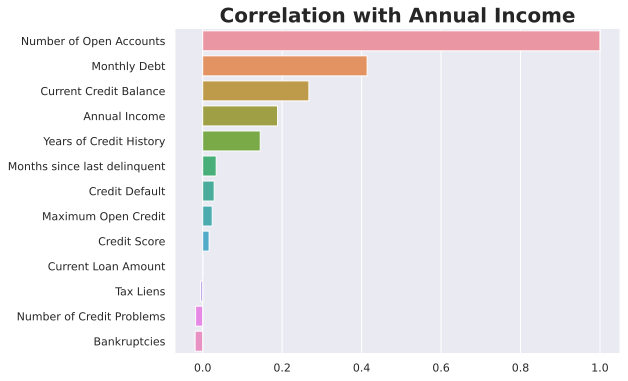

In [22]:
plt.figure(figsize=(8, 6))
sns.barplot(x=train.corr().iloc[:, 2].sort_values(ascending=False).values, 
            y=train.corr().iloc[:, 2].sort_values(ascending=False).index)
plt.title('Correlation with Annual Income', fontdict=title_dict);

Сумма «Ежемесячного долга» зависит от «Годового дохода». Рассчитаем отношение среднего дохода к среднему долгу

In [23]:

notnull_income = train.loc[train['Annual Income'].notnull(), :]
dev = notnull_income['Annual Income'].mean() / notnull_income['Monthly Debt'].mean()
train['Annual Income'].fillna(train['Monthly Debt'] * dev, inplace=True)
test['Annual Income'].fillna(test['Monthly Debt'] * dev, inplace=True)

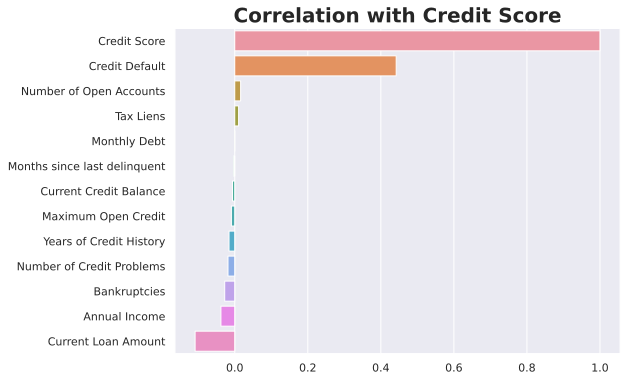

In [24]:
plt.figure(figsize=(8, 6))
sns.barplot(x=train.corr().iloc[:, -2].sort_values(ascending=False).values, 
            y=train.corr().iloc[:, -2].sort_values(ascending=False).index)
plt.title('Correlation with Credit Score', fontdict=title_dict);

«Кредитный рейтинг» сильно коррелирует с целевой переменной.

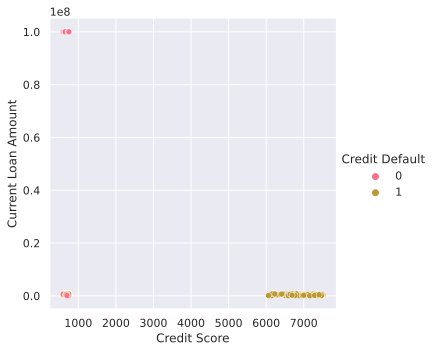

In [25]:
sns.relplot(x="Credit Score", y="Current Loan Amount", hue='Credit Default', data=train);

In [26]:
train['Credit Score'].fillna(3000, inplace=True)

In [27]:
test['Credit Score'].fillna(3000, inplace=True)

In [28]:
fill_col('Bankruptcies')
fill_col_test('Bankruptcies')

### Пробелы в номинативных признаках

In [29]:
def fill_nom_col(col):   
    '''Fill the gaps with the mode'''
    train[col].fillna(train[col].mode().iloc[0], inplace=True)

In [30]:
def fill_nom_col_test(col):  
    '''Fill the gaps with the mode estimated on Train'''
    test[col].fillna(train[col].mode().iloc[0], inplace=True)

In [31]:
fill_nom_col('Years in current job')
fill_nom_col_test('Years in current job')

## Анализ данных

Text(0.5, 1.0, 'Correlation matrix')

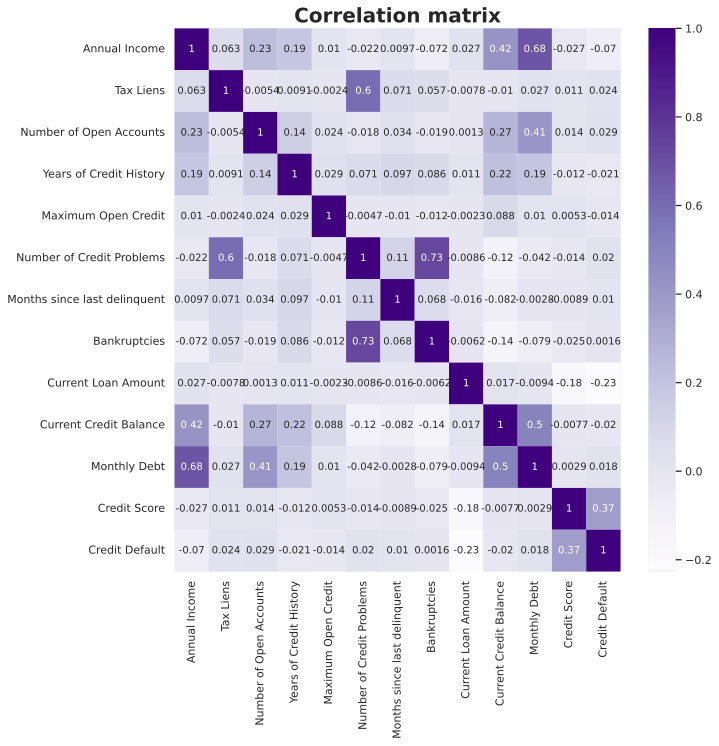

In [36]:
plt.figure(figsize=(10, 10))
sns.heatmap(train.corr(), cmap='Purples', annot=True)
plt.title('Correlation matrix', fontdict=title_dict)

### Обзор целевой переменной

In [37]:
train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [38]:
target = 'Credit Default'

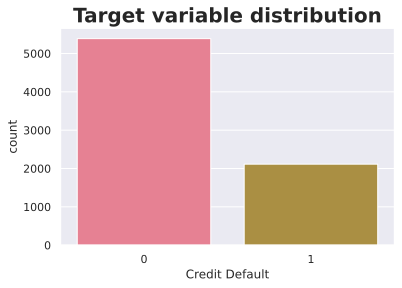

In [39]:
plt.figure(figsize=(6, 4))
sns.countplot(x=target, data=train)
plt.title('Target variable distribution', fontdict=title_dict);

Выборка не уравновешена целевой переменной

*Замена выбросов на медианные значения*

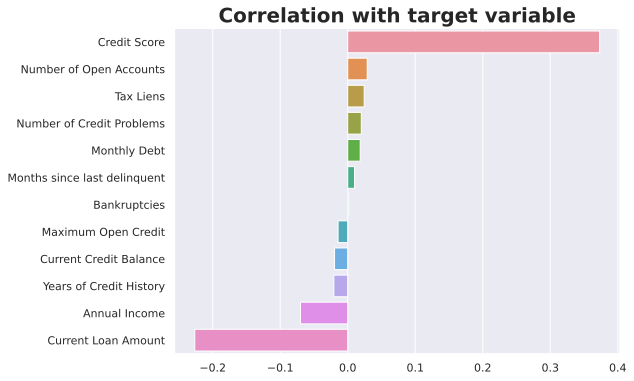

In [40]:
corr_with_target = train.corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable', fontdict=title_dict);

In [41]:
def feat_plot(col):        
    fig, ax = plt.subplots(nrows=2, ncols=2)
    ax1, ax2, ax3, ax4 = ax.flatten()
    
    default = train.loc[train ['Credit Default'] == 1, col]
    not_default = train.loc[train ['Credit Default'] == 0, col]
    ax1.hist((default, not_default), 
             bins=20, 
             histtype='stepfilled', 
             alpha=0.3, 
             color=('red', 'green'), 
             density=True, 
             label=('Credit Default 1', 'Credit Default 0'))
    ax1.legend(loc='upper right', frameon=False)
    ax1.set_title(col)
     
    ax2.boxplot(train[col])
    ax2.set_title(col)
    
   # Let's compare with the testing dataset.
    ax3.hist(test[col], bins=20)
    ax3.set_title('Test')
    
    ax4.boxplot(test[col])
    ax4.set_title('Test')
    
    fig.set_size_inches(10, 8)
    plt.subplots_adjust(wspace=0.3, hspace=0.3) 

In [42]:
def change_col(col):
    ''''''
    max_ = train[col].quantile(.99)
    min_ = train[col].quantile(.01)
    train.loc[train[col] > train[col].quantile(.99), col] = max_
    train.loc[train[col] < train[col].quantile(.01), col] = min_

In [43]:
def change_col_test(col):
    ''''''
    max_ = train[col].quantile(.99)
    min_ = train[col].quantile(.01)
    test.loc[test[col] > test[col].quantile(.99), col] = max_
    test.loc[test[col] < test[col].quantile(.01), col] = min_

### Годовой доход

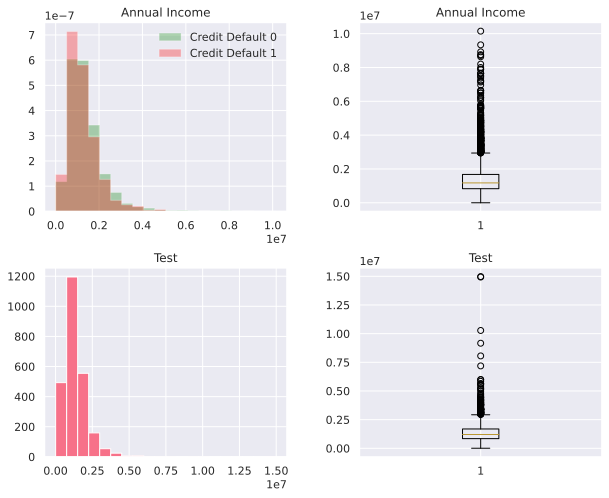

In [44]:
feat_plot('Annual Income')

In [45]:
# change_col('Annual Income')
# change_col_test('Annual Income')
# feat_plot('Annual Income')

### Налог

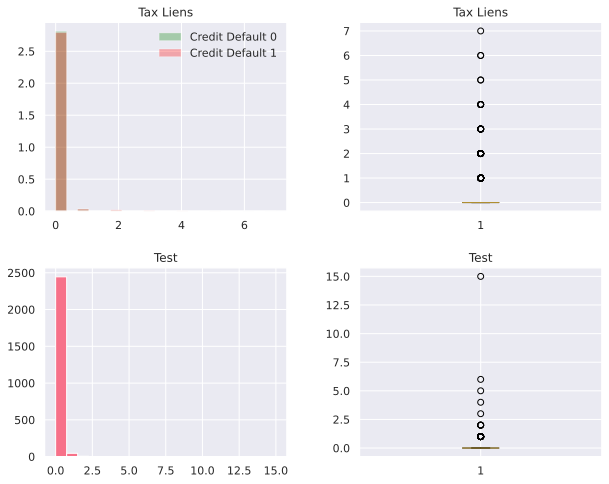

In [46]:
feat_plot('Tax Liens')


*Налоги-это категорический признак*

In [47]:
train['Tax Liens'].unique()

array([0., 3., 1., 2., 4., 6., 5., 7.])

In [48]:
train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

*Приведем признак "Налоги" к бинарному типу. 1 есть 0 нет*

In [49]:
train.loc[train['Tax Liens'] > 0, 'Tax Liens'] = 1
train['Tax Liens'] = train['Tax Liens'].astype('int')

Вносим изменения для тестирования

In [50]:
test.loc[test['Tax Liens'] > 0, 'Tax Liens'] = 1
test['Tax Liens'] = test['Tax Liens'].astype('int')

### Количество открытых счетов

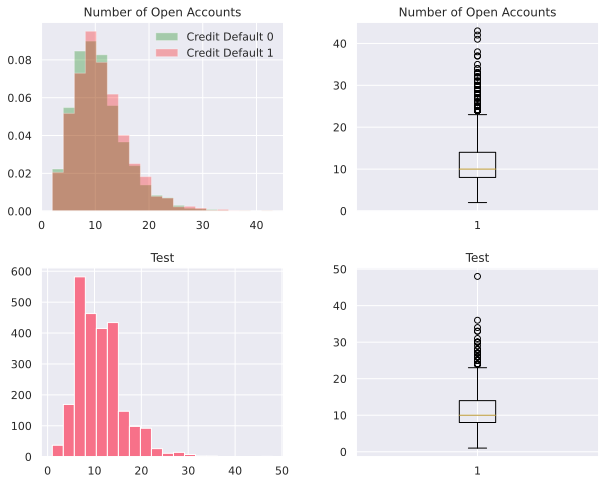

In [51]:
feat_plot('Number of Open Accounts')


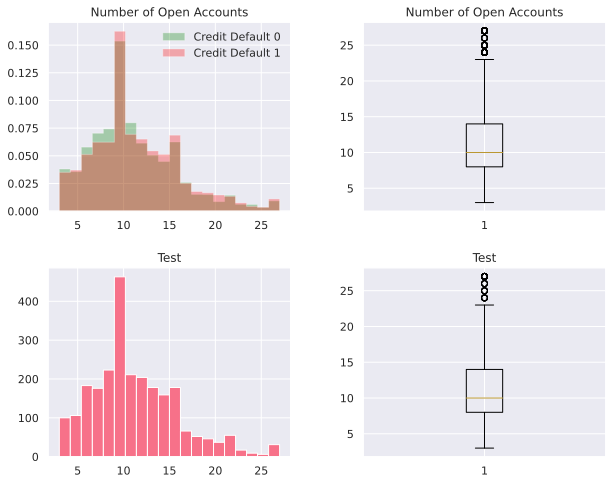

In [52]:
change_col('Number of Open Accounts')
change_col_test('Number of Open Accounts')
feat_plot('Number of Open Accounts')

### Количество лет кредитной истории

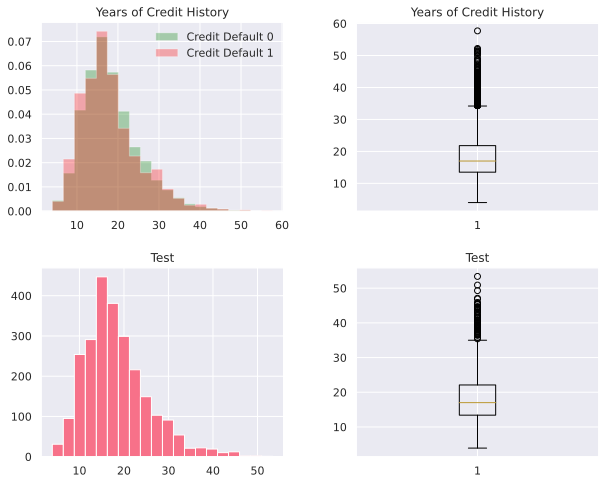

In [53]:
feat_plot('Years of Credit History')

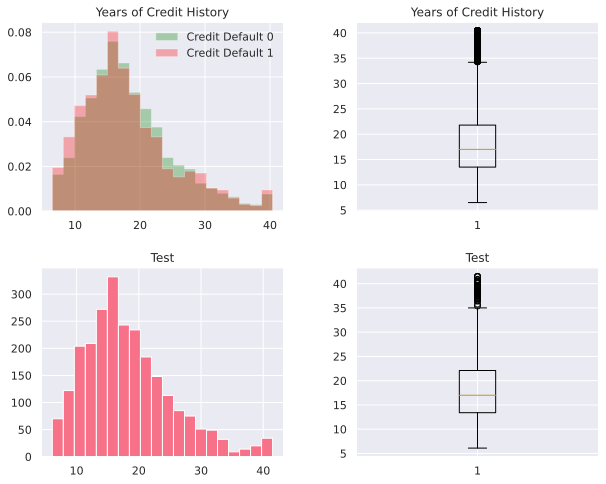

In [54]:
change_col('Years of Credit History')
change_col_test('Years of Credit History')
feat_plot('Years of Credit History')

### Наибольший открытый кредит

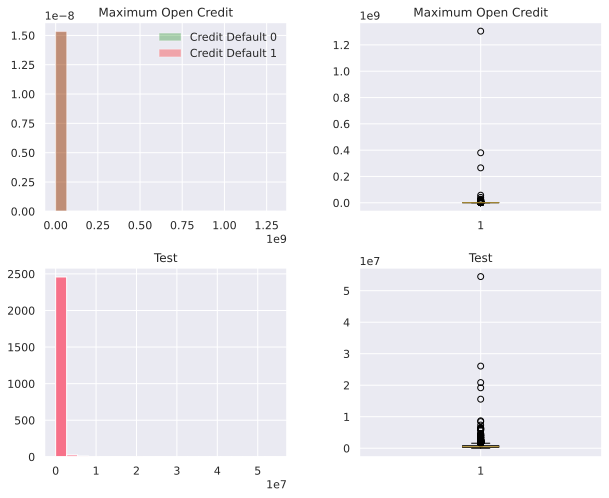

In [55]:
feat_plot('Maximum Open Credit')


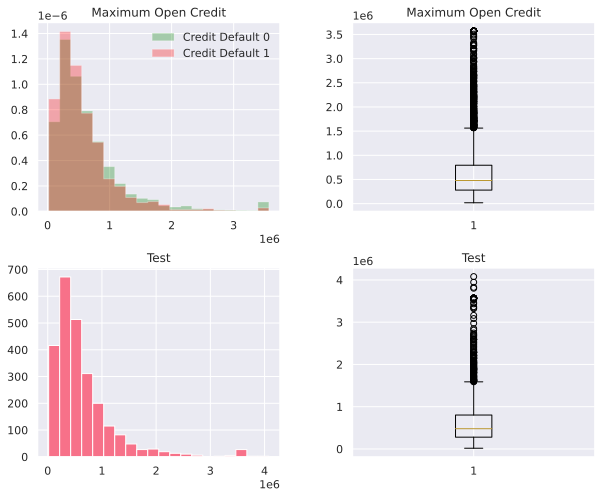

In [56]:
change_col('Maximum Open Credit')
change_col_test('Maximum Open Credit')
feat_plot('Maximum Open Credit')

### Количество проблем с кредитом

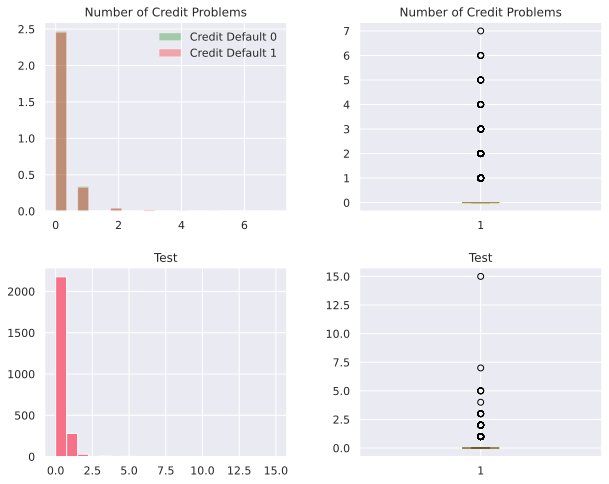

In [57]:
feat_plot('Number of Credit Problems')


Количество проблем с кредитом- это категорический признак

In [58]:
train['Number of Credit Problems'].unique()


array([1., 0., 3., 2., 6., 4., 5., 7.])

Присвойте метку 0 тем, у кого не было проблем с кредитом, и 1 – тем, у кого были.

In [59]:
train.loc[train['Number of Credit Problems'] > 0, 'Number of Credit Problems'] = 1
train['Number of Credit Problems'] = train['Number of Credit Problems'].astype('int')

In [60]:
test.loc[test['Number of Credit Problems'] > 0, 'Number of Credit Problems'] = 1
test['Number of Credit Problems'] = test['Number of Credit Problems'].astype('int')

### Количество месяцев с последней просрочки платежа

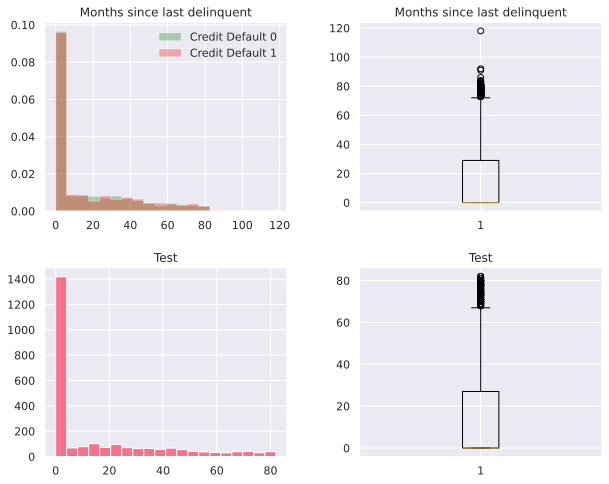

In [61]:
feat_plot('Months since last delinquent')


1 - задержка была, 0 - нет.

In [62]:
train.loc[train['Months since last delinquent'] > 0, 'Months since last delinquent'] = 1
train['Months since last delinquent'] = train['Months since last delinquent'].astype('int')

In [63]:
test.loc[test['Months since last delinquent'] > 0, 'Months since last delinquent'] = 1
test['Months since last delinquent'] = test['Months since last delinquent'].astype('int')

### Банкротства

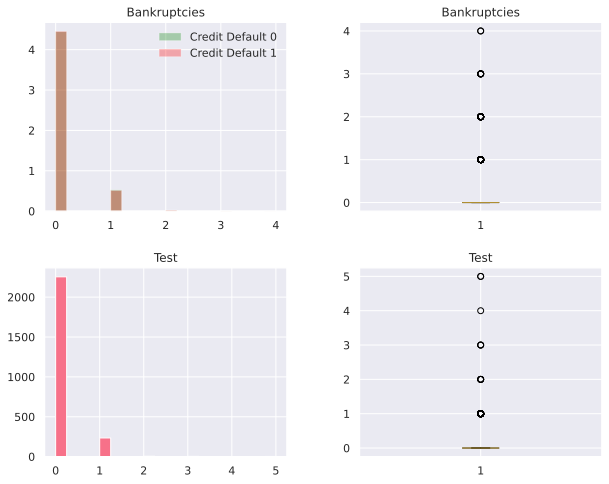

In [64]:
feat_plot('Bankruptcies')


Банкротство- это категорический признак

In [65]:
train['Bankruptcies'].unique()

array([1., 0., 3., 2., 4.])

Мы присвоим метку 0 тем, у кого не было банкротств, и 1 всем остальным.

In [66]:
train.loc[train['Bankruptcies'] > 0, 'Bankruptcies'] = 1
train['Bankruptcies'] = train['Bankruptcies'].astype('int')

In [67]:
test.loc[test['Bankruptcies'] > 0, 'Bankruptcies'] = 1
test['Bankruptcies'] = test['Bankruptcies'].astype('int')

### Текущая сумма кредита

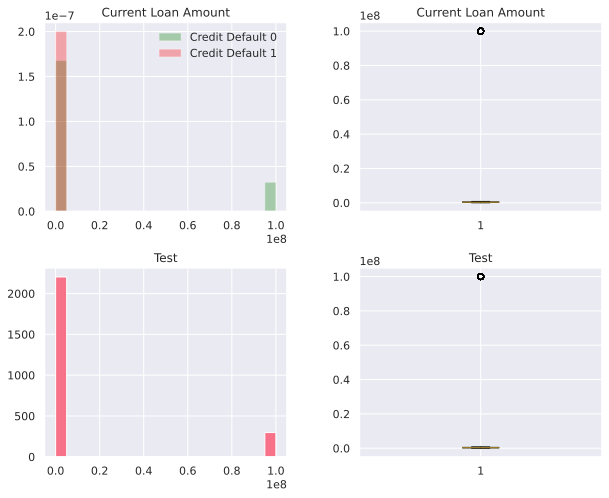

In [68]:
feat_plot('Current Loan Amount')

In [69]:
train.loc[train['Current Loan Amount'] == 99999999.0].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,8.700000e+02,870.000000,870.000000,870.000000,8.700000e+02,870.000000,870.000000,870.000000,870.0,8.700000e+02,870.000000,870.000000,870.0
mean,1.427779e+06,0.014943,11.108046,18.491615,6.879436e+05,0.134483,0.422989,0.105747,99999999.0,3.028599e+05,17933.028736,730.225287,0.0
std,8.998839e+05,0.121393,4.689170,6.890013,6.101708e+05,0.341367,0.494318,0.307691,0.0,3.590877e+05,12264.380264,21.395230,0.0
min,2.167140e+05,0.000000,3.000000,6.500000,1.726978e+04,0.000000,0.000000,0.000000,99999999.0,0.000000e+00,0.000000,601.000000,0.0
25%,8.668560e+05,0.000000,8.000000,13.725000,3.001625e+05,0.000000,0.000000,0.000000,99999999.0,1.145225e+05,9484.750000,726.000000,0.0
50%,1.245507e+06,0.000000,10.000000,17.200000,5.155040e+05,0.000000,0.000000,0.000000,99999999.0,2.134650e+05,15445.500000,737.000000,0.0
75%,1.726886e+06,0.000000,14.000000,22.350000,8.601725e+05,0.000000,1.000000,0.000000,99999999.0,3.633702e+05,23421.250000,744.000000,0.0
max,8.758449e+06,1.000000,27.000000,40.401000,3.568459e+06,1.000000,1.000000,1.000000,99999999.0,4.249673e+06,94674.000000,751.000000,0.0


*Целевая переменная в этих строках равна 0, а значение «Кредитный балл» близко к среднему, 730. Выделим эти строки в отдельный класс.*

In [70]:
train['Loan Amount Cat'] = 1
train.loc[train['Current Loan Amount'] == 99999999.0, 'Loan Amount Cat'] = 0

In [71]:
test['Loan Amount Cat'] = 1
test.loc[test['Current Loan Amount'] == 99999999.0, 'Loan Amount Cat'] = 0

### Текущий кредитный баланс

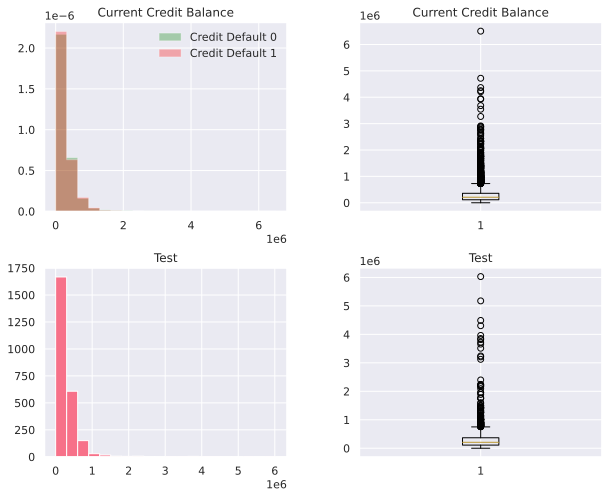

In [72]:
feat_plot('Current Credit Balance')

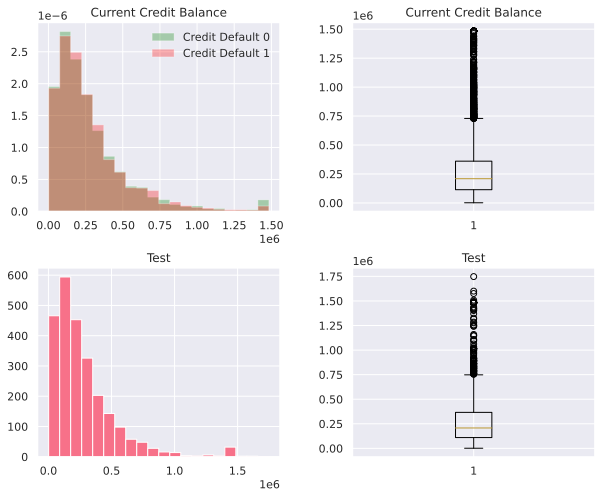

In [73]:
change_col('Current Credit Balance')
change_col_test('Current Credit Balance')
feat_plot('Current Credit Balance')

### Ежемесячный долг

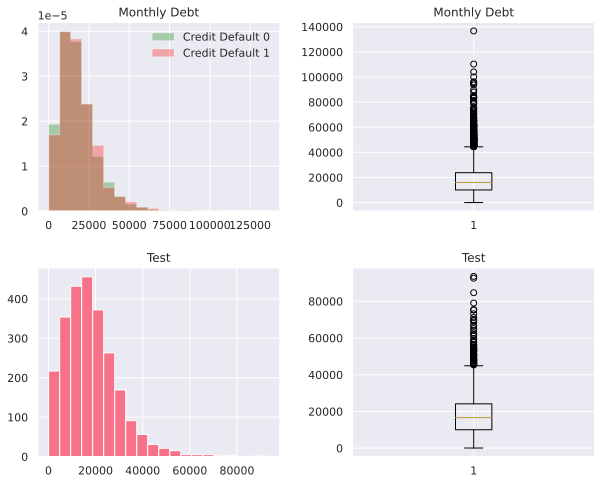

In [74]:
feat_plot('Monthly Debt')

In [75]:
# change_col('Monthly Debt')
# change_col_test('Monthly Debt')
# feat_plot('Monthly Debt')

### Кредитный рейтинг

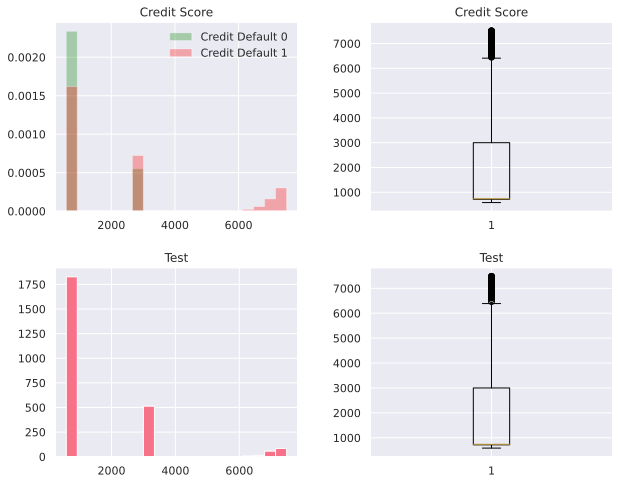

In [76]:
feat_plot('Credit Score')

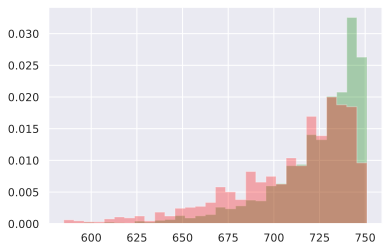

In [77]:
default = train.loc[
        (train ['Credit Default'] == 1) & (train['Credit Score'] < 800), 'Credit Score'
]
not_default = train.loc[
        (train ['Credit Default'] == 0) & (train['Credit Score'] < 800), 'Credit Score'
]
plt.hist((default, not_default), 
         bins=30, 
         histtype='stepfilled', 
         alpha=0.3, 
         color=('red', 'green'), 
         density=True, 
         label=('Credit Default 1', 'Credit Default 0')
);

In [78]:
train['Credit Score Cat'] = 0
train.loc[(train['Credit Score'] > 800), 'Credit Score Cat'] = 1
train.loc[(train['Credit Score'] == 3000), 'Credit Score Cat'] = 2
train.loc[(train['Credit Score'] < 735), 'Credit Score Cat'] = 2
train['Credit Score Cat'].astype('str')

0       0
1       0
2       0
3       2
4       2
       ..
7495    2
7496    1
7497    0
7498    2
7499    2
Name: Credit Score Cat, Length: 7500, dtype: object

In [79]:
test['Credit Score Cat'] = 0
test.loc[(test['Credit Score'] > 800), 'Credit Score Cat'] = 1
test.loc[(test['Credit Score'] == 3000), 'Credit Score Cat'] = 2
test.loc[(test['Credit Score'] < 735), 'Credit Score Cat'] = 2
test['Credit Score Cat'].astype('str')

0       2
1       2
2       1
3       0
4       2
       ..
2495    0
2496    2
2497    2
2498    0
2499    1
Name: Credit Score Cat, Length: 2500, dtype: object

## Обзор категорийных функций

In [80]:
for cat_colname in train.select_dtypes(include='object').columns:
    print(str(cat_colname) + 
          '\n\n' + 
          str(train[cat_colname].value_counts()) + 
          '\n' + 
          '*' * 79 + 
          '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
*******************************************************************************

Years in current job

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
*******************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy       

In [81]:
def countplot(feature):
    '''Feature values grouped by the target variable.'''
    plt.figure(figsize=(10, 6))
    sns.countplot(y=feature, hue=target, data=train)
    plt.legend(title='Target', loc='lower right')

### Домовладение

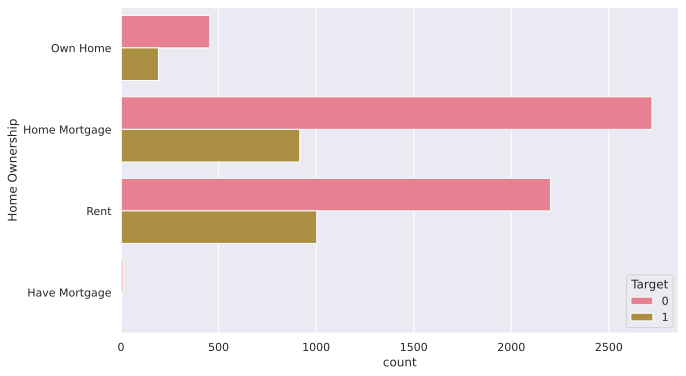

In [82]:
countplot("Home Ownership")

In [83]:
train.loc[train["Home Ownership"] == 'Have Mortgage', "Home Ownership"] = 'Home Mortgage'
test.loc[test["Home Ownership"] == 'Have Mortgage', "Home Ownership"] = 'Home Mortgage'

### Количество лет на текущем месте работы

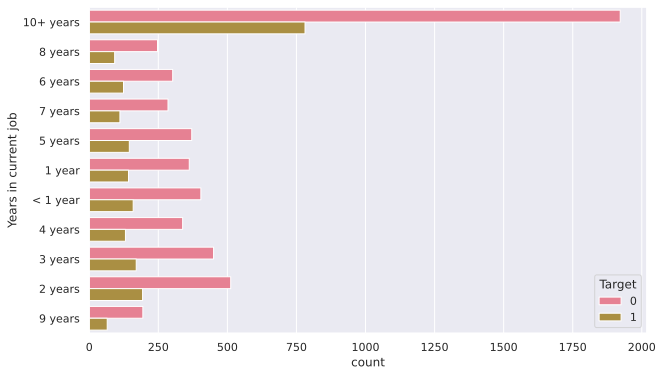

In [84]:
countplot("Years in current job")

In [85]:
train["Years in current job"].value_counts()

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [86]:
replace_dict = {'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5,
                '6 years':6, '7 years':7, '8 years':8, '9 years':9, '10+ years':10}

train['Years in current job'].replace(replace_dict, inplace=True)
test['Years in current job'].replace(replace_dict, inplace=True)

### Цель кредита

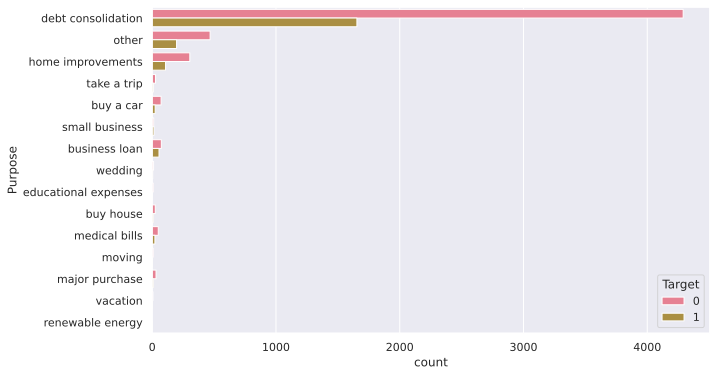

In [87]:
countplot("Purpose")

Объединим категории «бизнес-кредит» и «малый бизнес», у них большая доля невозврата кредита и другие маленькие категории.

In [88]:
train.loc[train['Purpose'] == 'small business', 'Purpose'] = 'business loan'
train.loc[train['Purpose'] == 'buy a car', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'medical bills', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'take a trip', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'buy house', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'wedding', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'moving', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'educational expenses', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'vacation', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'renewable energy', 'Purpose'] = 'major purchase'

In [89]:
train['Purpose'].value_counts()

debt consolidation    5944
other                  665
home improvements      412
major purchase         324
business loan          155
Name: Purpose, dtype: int64

In [90]:
test.loc[test['Purpose'] == 'small business', 'Purpose'] = 'business loan'
test.loc[test['Purpose'] == 'buy a car', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'medical bills', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'take a trip', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'buy house', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'wedding', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'moving', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'educational expenses', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'vacation', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'renewable energy', 'Purpose'] = 'major purchase'

### Срок кредита

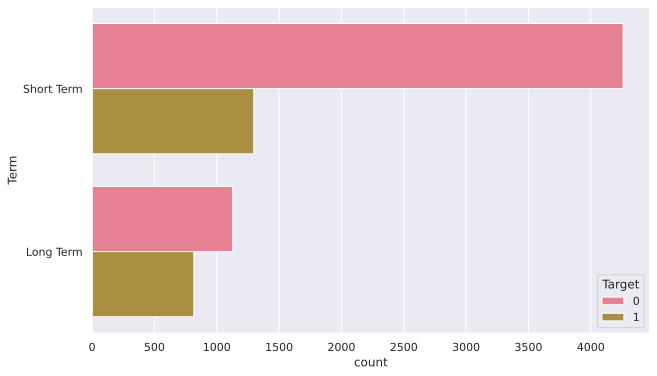

In [91]:
countplot("Term")

Пусть Short Term будет 0, а Long Term-1.

In [92]:
train.loc[train['Term'] == 'Long Term', 'Term'] = 1
train.loc[train['Term'] == 'Short Term', 'Term'] = 0
train['Term'] = train['Term'].astype('int')

In [93]:
test.loc[test['Term'] == 'Long Term', 'Term'] = 1
test.loc[test['Term'] == 'Short Term', 'Term'] = 0
test['Term'] = test['Term'].astype('int')

In [94]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   int64  
 3   Tax Liens                     7500 non-null   int64  
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   int64  
 8   Months since last delinquent  7500 non-null   int64  
 9   Bankruptcies                  7500 non-null   int64  
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   int64  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

# Выбор функций

In [106]:
basic_features = train.columns.drop(target).tolist()
basic_features

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Loan Amount Cat',
 'Credit Score Cat',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_business loan',
 'Purpose_debt consolidation',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_other']

In [107]:
numeric_features = train.select_dtypes(
                    include='float').columns.tolist()
numeric_features

['Annual Income',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [108]:
category_features = train.select_dtypes(
                    include=('object')).columns.tolist()
category_features

[]

In [109]:
CAT_DATASET_PATH = 'for_cat.csv'
train.to_csv(CAT_DATASET_PATH, index=False, encoding='utf-8')

CAT_TEST_DATASET_PATH = 'for_cat_test.csv'
test.to_csv(CAT_TEST_DATASET_PATH, index=False, encoding='utf-8')

In [110]:
selected_features = basic_features
selected_features

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Loan Amount Cat',
 'Credit Score Cat',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_business loan',
 'Purpose_debt consolidation',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_other']

### Манекены

In [111]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

### Новые списки функций

In [112]:
basic_feats = train.columns.drop(target).tolist()

In [113]:
numeric_feats = train.select_dtypes(include='float').columns.tolist()

In [114]:
category_feats = train.select_dtypes(include=('uint8')).columns.tolist()

In [115]:
selected_feats = basic_feats

***Посмотрим на корреляцию признаков с целевой переменной.***

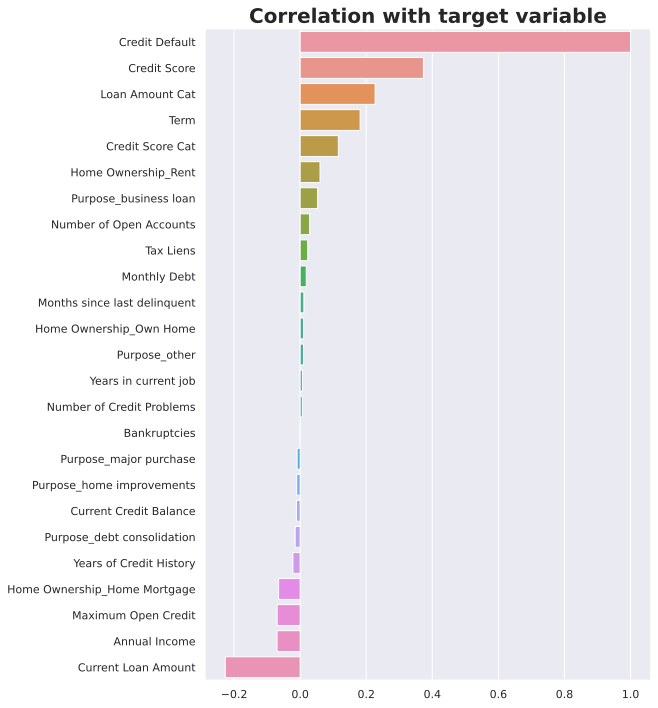

In [116]:
corr_with_target = train[selected_feats + 
                         [target]].corr().loc[target].sort_values(ascending=False)
plt.figure(figsize=(8, 12))
sns.barplot(x=corr_with_target.values, 
            y=corr_with_target.index)
plt.title('Correlation with target variable', 
          fontdict=title_dict);

# Нормализация данных, разделение на обучение и тестирование и балансировка целевых классов переменных.

In [117]:
def norm_data(train, test, features, scaler):
    '''Normalize the data'''
    train_norm = train.copy()
    train_norm[features] = scaler.fit_transform(train_norm[features])
    test_norm = test.copy()
    test_norm[features] = scaler.transform(test_norm[features])
    return train_norm, test_norm

In [119]:
train_norm, test_norm = norm_data(
    train, test, 
    numeric_feats, 
    MinMaxScaler()
)

In [120]:
train_standard, test_standard = norm_data(
    train, test, 
    numeric_feats, 
    StandardScaler()
)

In [121]:
def balance_df_by_target(df, target_name):
    '''Return balanced on Target dataset'''
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / 
                           target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(
                                target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [122]:
def split_and_balance_df(train_norm, selected_feats, test_size):
    '''Split train_norm to X_train, y_train and balance X_train'''
    X = train_norm[selected_feats]
    y = train_norm[target]
    X_train, X_test, y_train, y_test = train_test_split(
                X, y, shuffle=True, test_size=test_size, random_state=42)
    df_for_balancing = pd.concat([X_train, y_train], axis=1)
    df_balanced = balance_df_by_target(df_for_balancing, target)
    X_train = df_balanced.drop(columns=target)
    y_train = df_balanced[target]
    return X_train, X_test, y_train, y_test

In [123]:
X_train, X_test, y_train, y_test = split_and_balance_df(
        train_norm, selected_feats, test_size=0.25
)

In [124]:
X_train_s, X_test_s, y_train_s, y_test_s = split_and_balance_df(
        train_standard, selected_feats, test_size=0.25
)

# Построение и оценка базовых моделей.

In [125]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    '''Print the report'''
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [126]:
def model(model, X_train, y_train, X_test, y_test, features):
    '''Return model'''
    model.fit(X_train[features], y_train) 
    y_train_pred = model.predict(X_train[features])
    y_test_pred = model.predict(X_test[features])
    print(get_classification_report(y_train, y_train_pred, y_test, y_test_pred))
    return model

## LogisticRegression

In [127]:
model_lr = model(
            LogisticRegression(), 
            X_train, y_train, X_test, y_test, 
            features=selected_feats
)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.77      0.74      4074
           1       0.66      0.57      0.61      3102

    accuracy                           0.69      7176
   macro avg       0.68      0.67      0.67      7176
weighted avg       0.68      0.69      0.68      7176

TEST

              precision    recall  f1-score   support

           0       0.81      0.76      0.78      1313
           1       0.51      0.58      0.54       562

    accuracy                           0.70      1875
   macro avg       0.66      0.67      0.66      1875
weighted avg       0.72      0.70      0.71      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               995  318
1               236  326
None


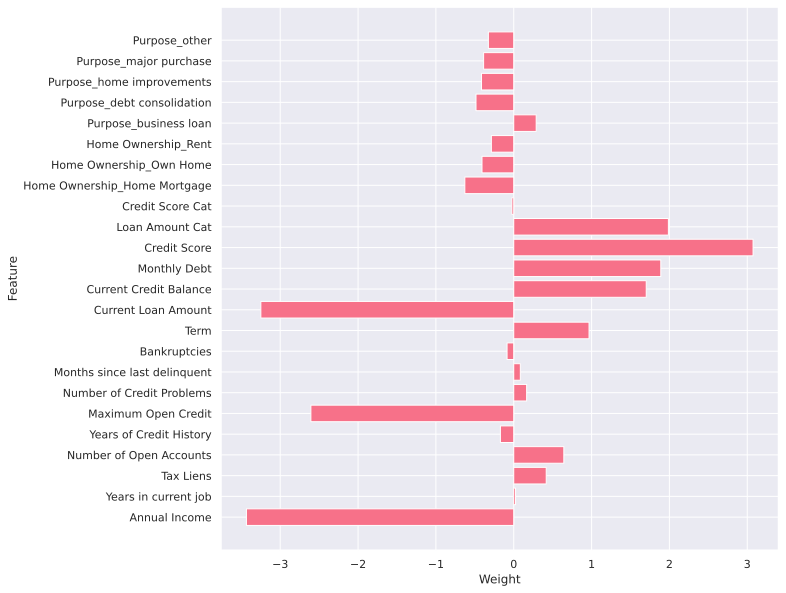

In [128]:
plt.rcParams['figure.figsize'] = 10, 10
plt.barh(selected_feats, model_lr.coef_.flatten())

plt.xlabel("Weight")
plt.ylabel("Feature")

plt.show()

In [129]:
selected_feats = np.array(selected_feats)
coefs = dict(zip(selected_feats, model_lr.coef_.flatten()))
new_feats = []
for feat, coef in coefs.items():
    if abs(coef) > 0.25:
        new_feats.append(feat)
new_feats

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Maximum Open Credit',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Loan Amount Cat',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_business loan',
 'Purpose_debt consolidation',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_other']

In [130]:
model_lr_new_feats = model(
                    LogisticRegression(), 
                    X_train, y_train, X_test, y_test, 
                    features=new_feats
)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.76      0.73      4074
           1       0.65      0.58      0.61      3102

    accuracy                           0.68      7176
   macro avg       0.68      0.67      0.67      7176
weighted avg       0.68      0.68      0.68      7176

TEST

              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1313
           1       0.51      0.60      0.55       562

    accuracy                           0.70      1875
   macro avg       0.66      0.67      0.66      1875
weighted avg       0.72      0.70      0.71      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               985  328
1               226  336
None


In [131]:
model_lr_s = model(
            LogisticRegression(), 
            X_train_s, y_train_s, X_test_s, y_test_s, 
            features=selected_feats
)

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.77      0.74      4074
           1       0.65      0.58      0.61      3102

    accuracy                           0.69      7176
   macro avg       0.68      0.67      0.67      7176
weighted avg       0.68      0.69      0.68      7176

TEST

              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1313
           1       0.51      0.59      0.55       562

    accuracy                           0.71      1875
   macro avg       0.66      0.67      0.66      1875
weighted avg       0.72      0.71      0.71      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               989  324
1               229  333
None


In [132]:
model_lr_s = model(
            LogisticRegression(),
            X_train_s, y_train_s, X_test_s, y_test_s, 
            features=new_feats
)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.77      0.73      4074
           1       0.65      0.58      0.61      3102

    accuracy                           0.68      7176
   macro avg       0.68      0.67      0.67      7176
weighted avg       0.68      0.68      0.68      7176

TEST

              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1313
           1       0.51      0.60      0.55       562

    accuracy                           0.70      1875
   macro avg       0.66      0.67      0.66      1875
weighted avg       0.72      0.70      0.71      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               982  331
1               224  338
None


In [135]:
# test_norm['Credit Default'] = model_lr_new_feats.predict(
#     test_norm[new_feats])
# PRED_PATH = 'AProdan_predictions.csv'
# test_norm.loc[:, ['Credit Default']].to_csv(
#     PRED_PATH, index=False, encoding='utf-8')

## RidgeClassifier

In [150]:
model_ridge = model(
            RidgeClassifier(), 
            X_train, y_train, X_test, y_test, 
            features=selected_feats
)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.79      0.74      4074
           1       0.66      0.55      0.60      3102

    accuracy                           0.69      7176
   macro avg       0.68      0.67      0.67      7176
weighted avg       0.68      0.69      0.68      7176

TEST

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1313
           1       0.52      0.58      0.55       562

    accuracy                           0.72      1875
   macro avg       0.67      0.68      0.67      1875
weighted avg       0.72      0.72      0.72      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1017  296
1                237  325
None


In [151]:
from sklearn.linear_model import RidgeClassifierCV

In [152]:
model_ridgeCV = model(
            RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100, 300]), 
            X_train, y_train, X_test, y_test, 
            features=selected_feats
)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.79      0.74      4074
           1       0.67      0.56      0.61      3102

    accuracy                           0.69      7176
   macro avg       0.68      0.67      0.67      7176
weighted avg       0.69      0.69      0.68      7176

TEST

              precision    recall  f1-score   support

           0       0.81      0.78      0.80      1313
           1       0.53      0.58      0.55       562

    accuracy                           0.72      1875
   macro avg       0.67      0.68      0.67      1875
weighted avg       0.73      0.72      0.72      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1025  288
1                238  324
None


## XGBoost

In [153]:
model_xgb = model(xgb.XGBClassifier(random_state=42),
                  X_train, y_train, X_test, y_test, 
                  features=selected_feats)

TRAIN

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4074
           1       0.98      0.97      0.97      3102

    accuracy                           0.98      7176
   macro avg       0.98      0.98      0.98      7176
weighted avg       0.98      0.98      0.98      7176

TEST

              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1313
           1       0.56      0.45      0.50       562

    accuracy                           0.73      1875
   macro avg       0.67      0.65      0.66      1875
weighted avg       0.72      0.73      0.72      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1113  200
1                309  253
None


In [154]:
model_xgb_s = model(xgb.XGBClassifier(random_state=42), 
                    X_train_s, y_train_s, X_test_s, y_test_s, 
                    features=selected_feats)

TRAIN

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4074
           1       0.98      0.97      0.97      3102

    accuracy                           0.98      7176
   macro avg       0.98      0.98      0.98      7176
weighted avg       0.98      0.98      0.98      7176

TEST

              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1313
           1       0.56      0.45      0.50       562

    accuracy                           0.73      1875
   macro avg       0.67      0.65      0.66      1875
weighted avg       0.72      0.73      0.72      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1113  200
1                309  253
None


In [155]:
# test_norm['Credit Default'] = model_xgb.predict(test_norm[selected_feats])
# PRED_PATH = 'AProdan_predictions.csv'
# test_norm.loc[:, ['Credit Default']].to_csv(
#     PRED_PATH, index=False, encoding='utf-8')

## LightGBM

In [156]:
model_lgbm = model(lgbm.LGBMClassifier(random_state=42, reg_lambda=300),
                  X_train, y_train, X_test, y_test, 
                  features=selected_feats)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.86      0.80      4074
           1       0.77      0.62      0.68      3102

    accuracy                           0.75      7176
   macro avg       0.76      0.74      0.74      7176
weighted avg       0.76      0.75      0.75      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1313
           1       0.56      0.52      0.54       562

    accuracy                           0.73      1875
   macro avg       0.68      0.67      0.67      1875
weighted avg       0.73      0.73      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1082  231
1                271  291
None


In [157]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    '''Return the list of the most important features'''
    feature_importances = pd.DataFrame(
            {'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values(
            'importance', ascending=False)
       
    plt.figure(figsize = (8, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

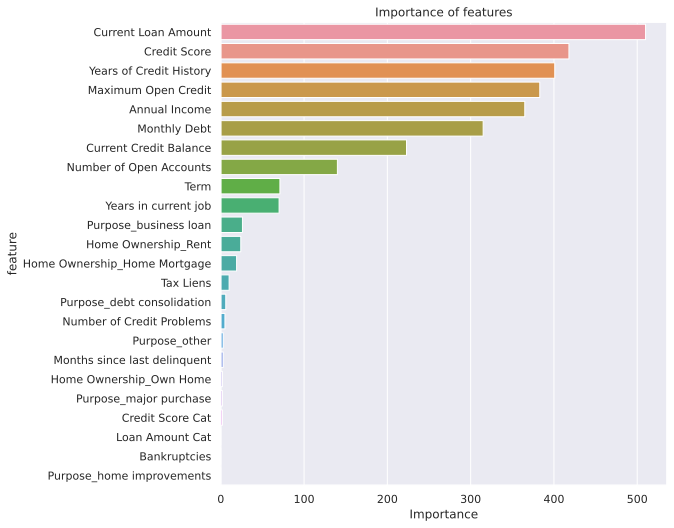

In [158]:
important_features_top = show_feature_importances(
        X_train.columns, 
        model_lgbm.feature_importances_, 
        get_top=15
)

In [159]:
model_lgbm_important_features_top = model(
                lgbm.LGBMClassifier(random_state=42, reg_alpha=7.0, reg_lambda=300.0),
                X_train, y_train, X_test, y_test, 
                features=important_features_top)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.86      0.79      4074
           1       0.76      0.59      0.67      3102

    accuracy                           0.75      7176
   macro avg       0.75      0.73      0.73      7176
weighted avg       0.75      0.75      0.74      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1313
           1       0.55      0.51      0.53       562

    accuracy                           0.73      1875
   macro avg       0.67      0.67      0.67      1875
weighted avg       0.72      0.73      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1083  230
1                277  285
None


In [160]:
# test_norm['Credit Default'] = model_lgbm_important_features_top.predict(test_norm[important_features_top])
# PRED_PATH = 'AProdan_predictions.csv'
# test_norm.loc[:, ['Credit Default']].to_csv(
#     PRED_PATH, index=False, encoding='utf-8')

In [161]:
model_lgbm_s = model(lgbm.LGBMClassifier(random_state=42, reg_lambda=300),
                  X_train_s, y_train_s, X_test_s, y_test_s, 
                  features=selected_feats)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.86      0.80      4074
           1       0.77      0.61      0.68      3102

    accuracy                           0.76      7176
   macro avg       0.76      0.74      0.74      7176
weighted avg       0.76      0.76      0.75      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1313
           1       0.56      0.51      0.53       562

    accuracy                           0.73      1875
   macro avg       0.68      0.67      0.67      1875
weighted avg       0.73      0.73      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1089  224
1                275  287
None


## CatBoost

In [162]:
train = pd.read_csv(CAT_DATASET_PATH)
test = pd.read_csv(CAT_TEST_DATASET_PATH)

In [163]:
train_norm_cat, test_norm_cat = norm_data(
    train, test, numeric_features, MinMaxScaler())

In [164]:
train_norm_cat_s, test_norm_cat_s = norm_data(
    train, test, numeric_features, StandardScaler())

In [165]:
(X_cat_train_without_norm, X_cat_test_without_norm, 
         y_cat_train_without_norm, y_cat_test_without_norm) = split_and_balance_df(
    train, selected_features, test_size=0.25)

In [166]:
X_cat_train, X_cat_test, y_cat_train, y_cat_test = split_and_balance_df(
    train_norm_cat, selected_features, test_size=0.25)

In [167]:
X_cat_train_s, X_cat_test_s, y_cat_train_s, y_cat_test_s = split_and_balance_df(
    train_norm_cat_s, selected_features, test_size=0.25)

In [168]:
model_catb_without_norm = model(catb.CatBoostClassifier
                   (cat_features=category_features, 
                     l2_leaf_reg=300, 
                     random_state=42, 
                     silent=True), 
                   X_cat_train_without_norm, y_cat_train_without_norm, 
                   X_cat_test_without_norm, y_cat_test_without_norm, 
                   features=selected_features)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.89      0.83      4074
           1       0.82      0.64      0.72      3102

    accuracy                           0.79      7176
   macro avg       0.80      0.77      0.77      7176
weighted avg       0.79      0.79      0.78      7176

TEST

              precision    recall  f1-score   support

           0       0.79      0.84      0.82      1313
           1       0.57      0.49      0.53       562

    accuracy                           0.74      1875
   macro avg       0.68      0.67      0.67      1875
weighted avg       0.73      0.74      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1104  209
1                286  276
None


In [169]:
model_catb = model(catb.CatBoostClassifier
                   (cat_features=category_features,
                    l2_leaf_reg=300,
                     random_state=42, 
                     silent=True), 
                   X_cat_train, y_cat_train, 
                   X_cat_test, y_cat_test, 
                   features=selected_features)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.90      0.83      4074
           1       0.83      0.66      0.73      3102

    accuracy                           0.79      7176
   macro avg       0.80      0.78      0.78      7176
weighted avg       0.80      0.79      0.79      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1313
           1       0.57      0.50      0.53       562

    accuracy                           0.74      1875
   macro avg       0.68      0.67      0.68      1875
weighted avg       0.73      0.74      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1105  208
1                283  279
None


In [170]:
model_catb_s = model(catb.CatBoostClassifier
                     (cat_features=category_features, 
                       l2_leaf_reg=300, 
                       random_state=42, 
                       silent=True), 
                     X_cat_train_s, y_cat_train_s, 
                     X_cat_test_s, y_cat_test_s, 
                     features=selected_features)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.89      0.82      4074
           1       0.82      0.64      0.72      3102

    accuracy                           0.78      7176
   macro avg       0.79      0.76      0.77      7176
weighted avg       0.79      0.78      0.78      7176

TEST

              precision    recall  f1-score   support

           0       0.79      0.84      0.82      1313
           1       0.57      0.49      0.53       562

    accuracy                           0.74      1875
   macro avg       0.68      0.67      0.67      1875
weighted avg       0.73      0.74      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1108  205
1                288  274
None


*Посмотрим, какие функции были наиболее важными*

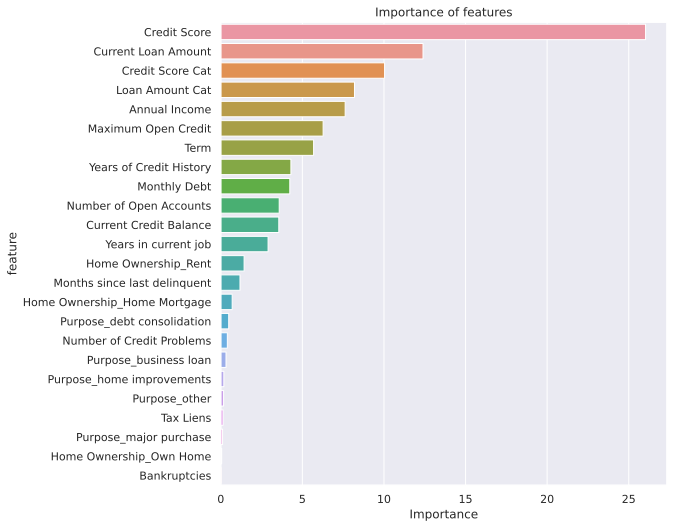

In [171]:
important_features_top = show_feature_importances(
                    X_cat_train_without_norm.columns, 
                    model_catb.feature_importances_, 
                    get_top=15
)

In [172]:
model_catb_without_norm_important_features_top = model(
                        catb.CatBoostClassifier
                        (cat_features=category_features, 
                          l2_leaf_reg=300, 
                          random_state=42, 
                          silent=True), 
                        X_cat_train_without_norm, y_cat_train_without_norm, 
                        X_cat_test_without_norm, y_cat_test_without_norm, 
                        features=important_features_top)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.89      0.82      4074
           1       0.82      0.64      0.72      3102

    accuracy                           0.78      7176
   macro avg       0.79      0.77      0.77      7176
weighted avg       0.79      0.78      0.78      7176

TEST

              precision    recall  f1-score   support

           0       0.79      0.84      0.82      1313
           1       0.57      0.49      0.53       562

    accuracy                           0.74      1875
   macro avg       0.68      0.67      0.67      1875
weighted avg       0.73      0.74      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1102  211
1                285  277
None


In [174]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      class_weights=[1, 3.5],
                                      silent=True, random_state=21)

In [177]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3, l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.88      0.80      4074
           1       0.78      0.57      0.66      3102

    accuracy                           0.74      7176
   macro avg       0.75      0.72      0.73      7176
weighted avg       0.75      0.74      0.74      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1313
           1       0.57      0.50      0.53       562

    accuracy                           0.74      1875
   macro avg       0.68      0.67      0.67      1875
weighted avg       0.73      0.74      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1103  210
1                282  280


In [182]:
test[['Current Loan Amount', 'Credit Score']].to_csv('AProdan_predict.csv', index=None)